In [76]:
import cv2
import time
import numpy as np
import onnxruntime as ort 
import torch
from PIL import Image, ImageDraw, ImageFont

print('device:', ort.get_device())

named_labels = {
    0: 'person',
    1: 'bicycle'
}

font = ImageFont.truetype('/home/kevin/Custom-RT-DETR/rtdetr_pytorch/font/Swansea-q3pd.ttf', 16)

def preprocess_input(frame):
    frame = cv2.resize(frame, (640, 640))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


providers = [("CUDAExecutionProvider", {"device_id": torch.cuda.current_device(),})]
sess_options = ort.SessionOptions()
ort_session = ort.InferenceSession('rtdetr_yolov9bb_ep27.onnx', sess_options=sess_options, providers=providers)
input_name = ort_session.get_inputs()[0].name  
input_shape = ort_session.get_inputs()[0].shape



device: GPU


2024-04-05 07:44:25.337168427 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-04-05 07:44:25.339081215 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [77]:
cap = cv2.VideoCapture('bicycle_thief.mp4')
if not cap.isOpened():
    print("Error opening video!")
    exit()

frames = [cap.read()[1] for i in range(100)]

frame shape: (720, 1280, 3)
preprocessed_frame (640, 640, 3)
input_data torch.Size([1, 3, 640, 640])
box [[400, 170, 472, 422]]
<class 'numpy.ndarray'>


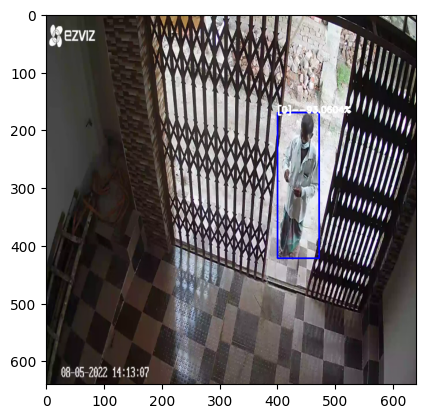

: 

In [88]:
from matplotlib import pyplot as plt
import copy 
from torchvision.transforms import ToTensor

start_time = time.time()
frame_count = 0

frame = copy.deepcopy(frames[99])
print('frame shape:', frame.shape)
    
if (type(frame)==bool) or (frame is None):
    print('bad frame 0')

totensor = ToTensor()
preprocessed_frame = preprocess_input(frame)  # Apply preprocessing
print('preprocessed_frame', preprocessed_frame.shape)
input_data = torch.stack([totensor(preprocessed_frame)])
print('input_data', input_data.shape)

# Run inference using ONNX Runtime
labels, boxes, scores = ort_session.run(None, {'images': input_data.data.numpy(), 'orig_target_sizes': torch.tensor([[640, 640]]).data.numpy()})
thrh = 0.7
# draw = ImageDraw.Draw(frame)
scr = scores[0]
lab = labels[0][scr > thrh]
box = [[int(j) for j in _box] for _box in boxes[0][scr > thrh]]
scr_str = '-'+str(round(scr[0]*100, 4))+'%'
lab_str = str(lab)+'-'
postprocessed_frame = preprocessed_frame.copy()
print('box', box)
for b in box:
    postprocessed_frame = cv2.rectangle(postprocessed_frame, tuple(b[:2]), tuple(b[2:4]), color=(0, 0, 255), thickness=2)  # Red rectangle
    postprocessed_frame = cv2.putText(postprocessed_frame, f"{lab_str}{scr_str}", tuple(b[:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)  # White text        
    # draw.rectangle(list(b), outline='red',)
    # draw.text((b[0], b[1]), text=f'{lab_str}{named_labels[lab[0]]}{scr_str}', fill='white', font=font)
# Process outputs (bounding boxes, scores, etc.) based on your model's format
# ... (Your model-specific output processing logic here)

# Update FPS calculation
frame_count += 1
elapsed_time = time.time() - start_time

if frame_count % 100 == 0:  # Calculate FPS every 100 frames
    fps = frame_count / elapsed_time
    print(f"FPS: {fps:.2f}")  # Display FPS with two decimal places
    
print(type(postprocessed_frame))

plt.imshow(postprocessed_frame)



(3, 640, 640)
(2, 3, 640, 640)


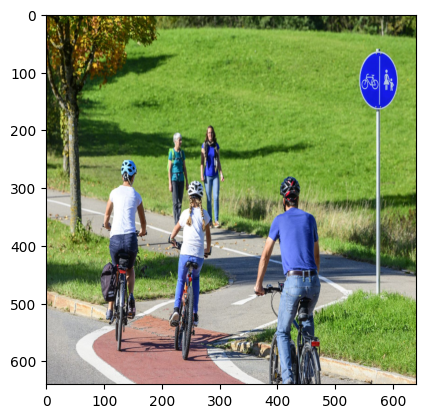

In [52]:
from torchvision.transforms import ToTensor
import numpy as np
from matplotlib.colors import BoundaryNorm, ListedColormap

cmap = ListedColormap(['r', 'g', 'b'])

img = cv2.resize(cv2.imread('/home/kevin/Custom-RT-DETR/rtdetr_pytorch/imgs/bicycle.jpeg'), (640, 640))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.transpose(img, (2, 0, 1))

print(img.shape)
imgs = np.array([
        img,
        img
    ])
print(imgs.shape)

plt.imshow(np.transpose(img, (1, 2, 0)), cmap=cmap)

In [33]:
totensor = ToTensor()
prep_imgs = torch.stack([totensor(np.transpose(i, (1, 2, 0))) for i in imgs])
print(prep_imgs.shape)
labels, boxes, scores = ort_session.run(None, {'images': prep_imgs.data.numpy(), 'orig_target_sizes': torch.tensor([[640, 640]]).data.numpy()})

print(len(labels), len(boxes), len(scores))

torch.Size([2, 3, 640, 640])
2 2 2


<class 'numpy.ndarray'> (640, 640, 3)
ori box len 10
- 93.5154 0 10
[98, 251, 174, 533]
[359, 280, 475, 638]
[265, 192, 308, 369]
[210, 286, 287, 544]
[209, 204, 247, 364]
[361, 464, 475, 640]
[107, 413, 148, 582]
[219, 416, 269, 598]
[544, 102, 575, 130]
[211, 287, 287, 543]
True
<class 'numpy.ndarray'> (640, 640, 3)
ori box len 10
- 93.4326 0 10
[98, 251, 174, 533]
[359, 280, 475, 638]
[265, 192, 308, 369]
[210, 286, 287, 544]
[209, 204, 247, 364]
[361, 464, 475, 640]
[107, 413, 148, 582]
[219, 416, 269, 598]
[544, 102, 575, 130]
[211, 287, 287, 543]
True


/tmp/ipykernel_20062/2584683781.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.any((im==img.copy())==False))


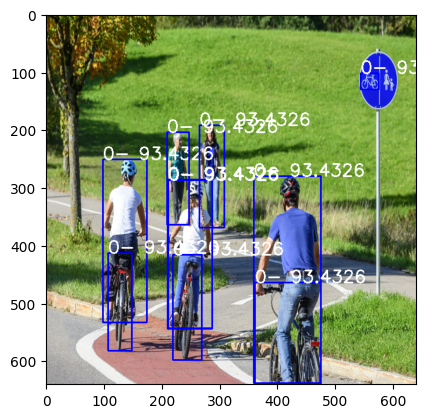

In [74]:
import copy

for i in range(len(imgs)):
    im = cv2.resize(cv2.imread('/home/kevin/Custom-RT-DETR/rtdetr_pytorch/imgs/bicycle.jpeg'), (640, 640))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    print(type(im), im.shape)
    thrh = 0.5
    scr = scores[i]
    lab = labels[i][scr > thrh]
    box = boxes[i][scr > thrh]
    print('ori box len', len(box))
    box = [[int(j) for j in _box] for _box in box]
    scr_str = '- '+str(round(scr[i]*100, 4))
    lab_str = lab[i]
    print(scr_str, lab_str, len(box))
    for b in box:
        print(b)
        im = cv2.rectangle(im, tuple(b[:2]), tuple(b[2:4]), color=(0, 0, 255), thickness=2)  # Red rectangle
        im = cv2.putText(im, f"{lab_str}{scr_str}", tuple(b[:2]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)  # White text        
    
    print(np.any((im==img.copy())==False))
    plt.imshow(np.transpose(im, (0, 1, 2)), cmap=cmap)
    